In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/deep_learning/HW4

/content/drive/.shortcut-targets-by-id/1v5fVXVsjR9cD7hVL0kK69N68E-Traw5Q/HW4


In [ ]:
!pip install torchtext==0.5.0
!pip install transformers
import numpy as np
import pandas as pd
from tqdm import tqdm 
import torch
import torchtext
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import Counter
!pip install https://github.com/sobhe/hazm/archive/master.zip --upgrade
from hazm import *
normalizer = Normalizer()

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
data = open('ferdousi.txt').read()
poems = data.lower().split("\n")[2:]

In [5]:

def build_vocab(corpus):
    
    counter = Counter()
    for text in tqdm(corpus):
        words = word_tokenize(normalizer.normalize(text))
        counter.update(words)
    print(counter)
    return Vocab(counter)

vocab = build_vocab(poems)

100%|██████████| 99217/99217 [00:14<00:00, 6887.98it/s] 

Counter({'و': 24170, 'به': 15052, 'که': 12039, 'ز': 11816, 'از': 9973, 'بر': 7777, 'را': 7561, 'چو': 6403, 'با': 4626, 'همی': 4563, 'گفت': 4266, 'شاه': 4044, 'تو': 4040, 'شد': 3755, 'بود': 3603, 'او': 3515, 'یکی': 3378, 'همه': 3293, 'آن': 3157, 'اندر': 2896, 'من': 2852, 'در': 2710, 'تا': 2642, 'سر': 2553, 'دل': 2549, 'چنین': 2531, 'کرد': 2503, 'آمد': 2442, 'پیش': 2408, 'این': 2240, 'جهان': 2175, 'بد': 2096, 'پر': 2043, 'بدو': 2029, 'هر': 1894, 'سپاه': 1796, 'چون': 1773, 'داد': 1738, 'پس': 1736, 'دو': 1677, 'نه': 1646, 'راه': 1573, 'روی': 1546, 'سوی': 1519, 'کار': 1517, 'لشکر': 1493, 'چه': 1456, 'سخن': 1443, 'تخت': 1428, 'بی': 1417, 'هم': 1396, 'ما': 1379, 'مرد': 1309, 'جنگ': 1292, 'جای': 1257, 'مرا': 1257, 'دست': 1248, 'زمین': 1245, 'گرد': 1245, 'ایران': 1220, 'گشت': 1210, 'بیامد': 1194, 'همان': 1184, 'روز': 1159, 'یک': 1139, 'باد': 1133, 'بدین': 1074, 'شهریار': 1073, 'کسی': 1069, 'رای': 1059, 'بدان': 1058, 'خویش': 1045, 'کس': 1036, 'ازان': 1034, 'تن': 1007, 'تاج': 1004, 'اگر': 980, 'ن

In [6]:
def data_process(corpus, vocab):
    data = list()
    for text in tqdm(corpus):
        token_list = [vocab[token] for token in word_tokenize(normalizer.normalize(text))]
        for i in range(1, len(token_list)):
            n_gram_seq = torch.tensor(token_list[:i+1], dtype=torch.long)
            data.append(n_gram_seq)
    return data

train_data = data_process(poems, vocab)

100%|██████████| 99217/99217 [00:12<00:00, 7983.51it/s]


In [7]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True).reshape(y.size())
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc,top_pred

In [8]:
X = [i[:-1] for i in train_data]
y = [i[-1] for i in train_data]

X = pad_sequence(X, batch_first=True, padding_value=vocab.stoi['<pad>'])
y = torch.from_numpy(np.array(y))

train_data = TensorDataset(X, y)



In [9]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [25]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True).reshape(y.size())
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc,top_pred

# **LSTM Model**

In [28]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        out = self.embedding(X)
        out, (h, c) = self.lstm(out, (h, c))
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = out.view(-1, X.size(1), self.vocab_size)
        out = out[:, -1]
        
        return out, h, c
    
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        return hidden, cell

In [29]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 3

In [30]:
model = Net(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)


In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model.load_state_dict(torch.load("Ferdousi.pth"),strict = False)

In [32]:
EPOCHS = 50
losses = []
accs = []
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
      for i,(X, y) in pbar:
          X = X.to(DEVICE)
          y = y.to(DEVICE)
          optimizer.zero_grad()
          output, h, c = model(X)
          loss = criterion(output, y)
          acc , _ = calculate_accuracy(output, y)
          accuracy += acc
          epoch_loss += loss
          loss.backward()
          optimizer.step()
          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f} - Accuracy: {accuracy*100/(i+1):.2f}%')
      losses.append((epoch_loss/len(pbar)).cpu().item())
      accs.append((accuracy*100/len(pbar)).cpu().item())
      if (losses[-1]==min(losses)):
          torch.save(model.state_dict(), 'Ferdousi.pth')


  


EPOCH:50 - Loss: 3.5102 - Accuracy: 30.97%: 100%|██████████| 7263/7263 [01:18<00:00, 92.33it/s]


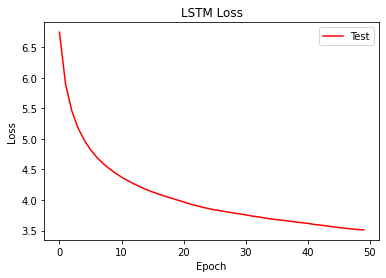

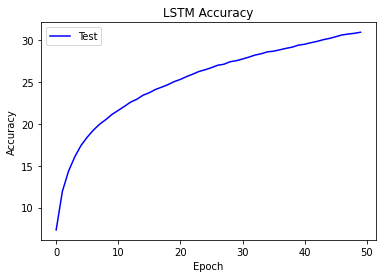

In [34]:
plt.plot(np.array(losses), 'r')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss_lstm.jpg')
plt.show()

plt.plot(np.array(accs), 'b')
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc_lstm.jpg')
plt.show()

# **GRU Model**

In [35]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        out = self.embedding(X)
        out, h = self.gru(out, h)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = out.view(-1, X.size(1), self.vocab_size)
        out = out[:, -1]
        
        return out, h, c
    
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        return hidden, cell

In [40]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 3

In [41]:
model_gru = GRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)


In [42]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
model_gru.load_state_dict(torch.load("Ferdousi_gru.pth"),strict = False)

<All keys matched successfully>

EPOCH:50 - Loss: 3.8162 - Accuracy: 26.84%: 100%|██████████| 7263/7263 [01:15<00:00, 96.44it/s]


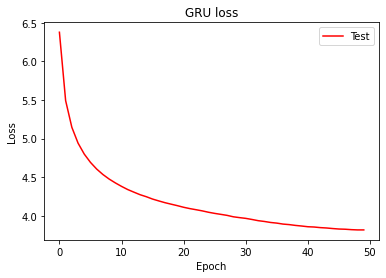

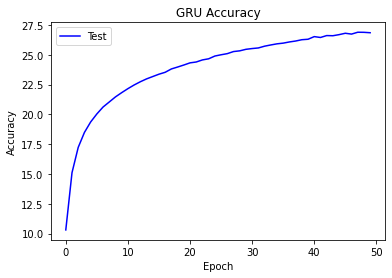

In [43]:
EPOCHS = 50
losses = []
accs = []
model_gru.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
      for i,(X, y) in pbar:
          X = X.to(DEVICE)
          y = y.to(DEVICE)
          optimizer.zero_grad()
          output, h, c = model_gru(X)
          loss = criterion(output, y)
          acc , _ = calculate_accuracy(output, y)
          accuracy += acc
          epoch_loss += loss
          loss.backward()
          optimizer.step()
          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f} - Accuracy: {accuracy*100/(i+1):.2f}%')
      losses.append((epoch_loss/len(pbar)).cpu().item())
      accs.append((accuracy*100/len(pbar)).cpu().item())
      #print(losses)
      #print(accs)
      if (losses[-1]==min(losses)):
          torch.save(model_gru.state_dict(), 'Ferdousi_gru.pth')



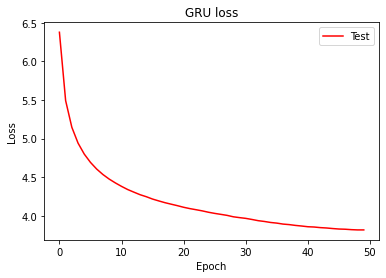

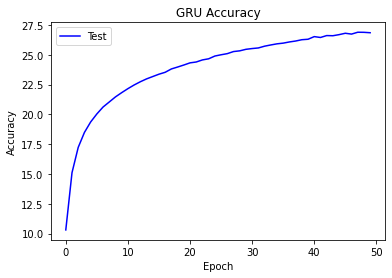

In [44]:
plt.plot(np.array(losses), 'r')
plt.title('GRU loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss_gru.jpg')
plt.show()

plt.plot(np.array(accs), 'b')
plt.title('GRU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc_gru.jpg')
plt.show()

# **Evaluate Models**




In [ ]:
BATCH_SIZE = 16
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

losses = []
epoch_loss = 0
model.eval()
model_gru.eval()
with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
  for i,(X, y) in pbar:
      X = X.to(DEVICE)
      y = y.to(DEVICE)
      optimizer.zero_grad()
      output, h, c = model(X)
      loss = criterion(output, y)
      epoch_loss += loss
      pbar.set_description(f'EVAL for LSTM: - Loss: {epoch_loss/(i+1):.4f}')
  losses.append(epoch_loss)

losses = []
epoch_loss = 0
with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
  for i,(X, y) in pbar:
      X = X.to(DEVICE)
      y = y.to(DEVICE)
      
      optimizer.zero_grad()
      output, h, c = model_gru(X)
      loss = criterion(output, y)
      epoch_loss += loss
      pbar.set_description(f'EVAL for GRU: - Loss: {epoch_loss/(i+1):.4f}')
  losses.append(epoch_loss)

# **Generating poem**

After running in different epochs and networks, I conclude that this network, with a learning rate of 1e-3 and a network with 3 hidden layers and 128 neurons in eac layer, is the best choice for our model. after that, the model converges to a static situation and will not give us good results.</br>
We can realize here that an LSTM model can generate more rational and proper responses than GRU one.

In [64]:
first_text = str(input("ابتدای شعر خود را وارد نمائید، یا میتوانید این بخش را خالی بگذارید: "))
#first_text = "به نام خدایی که جان آفرید" 
lenght_sent = len(first_text.split(' '))

seed_text = first_text
if (first_text==''):
  lenght_sent = 6
  next_words = 72
else:
  next_words = lenght_sent*11

print('\n: LSTM شعر سروده شده با مدل  \n')
last_idx = -1
i = 0
while i != next_words:
    token_list = np.ones(21, dtype=int)
    text_token = np.array([vocab[token] for token in word_tokenize(normalizer.normalize(seed_text))])
    if len(text_token)>21:
      text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(DEVICE)
    out,h,c = model(token_list)
    idx = torch.argmax(out)

    if last_idx != idx and vocab.itos[idx]!='؟':
      seed_text += " " + vocab.itos[idx]
      last_idx = idx
      i+=1

for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%lenght_sent==0:
        print("")


print("\n")
print(': GRU شعر سروده شده با مدل \n')
seed_text = first_text
i = 0
while i != next_words:
    token_list = np.ones(21, dtype=int)
    text_token = np.array([vocab[token] for token in word_tokenize(normalizer.normalize(seed_text))])
    if len(text_token)>21:
      text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(DEVICE)
    out,h,c = model_gru(token_list)
    idx = torch.argmax(out)

    if last_idx != idx and vocab.itos[idx]!='؟':
      seed_text += " " + vocab.itos[idx]
      last_idx = idx
      i+=1

for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%lenght_sent==0:
        print("")


ابتدای شعر خود را وارد نمائید، یا میتوانید این بخش را خالی بگذارید: بسی رنج بردم در این سال سی

: LSTM شعر سروده شده با مدل  

بسی رنج بردم در این سال سی 
وار و می‌غم بر کمند گران هین 
شیر نر دار موم خواست بر موم 
بر موم نشین قلم کشسب عاج غرو 
کشسب می‌برید خون تف باتاج غندی دوشیزه‌اند 
تیر مهربانی کار بر است نیست موم 
دار ترسید می‌برید گنبدان ترسید بر کار 
دست کفش می‌برید موم بر ببهشت کار 
بویهای اروندرود افزار کار بر باتاج کار 
تازید کار ترسید شطرنج کار اندورن فرستادمش 
آسانش کار دربان ارمان وخویشی کار بستانم 
کار سپردش سلهٔ سپارید سپردش شیراوژنا پشتش 


: GRU شعر سروده شده با مدل 

بسی رنج بردم در این سال سی 
انجمن نیز داد و جوان را ندید 
آوری بود نام تو بود یاد خواه 
است خواه نو یاد داد خواست دار 
نو دار راست یاد نو کرد نو 
داد نو را بدوی داد کرد نو 
راست مه چهر تو هست را است 
داد یاد نو دار نو راست دار 
نام برد نو داد دار یاد نو 
گفت نو داد نو را تست داد 
بیش و داد برد داد تو یاد 
خوان نو است داد دار است داد 
